In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

np.random.seed(1)

import warnings
warnings.filterwarnings('ignore')


## Data

We consider the [Kings County housing dataset](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction). It includes homes sold between May 2014 and May 2015.

Specifically, we focuse on the Rainier Valley zipcode.

In [6]:
# Load the dataset
house = pd.read_csv("data/rainier_valley_house.csv")

Here are the features:

In [7]:
house.columns

Index(['Unnamed: 0', 'id', 'date', 'price', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

number of houses:  508


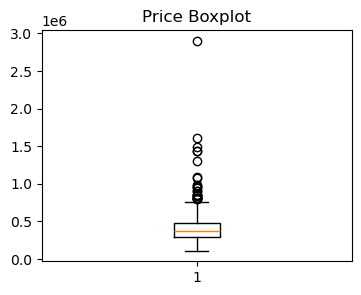

In [8]:
# number of houses
print(f"number of houses:  {house.shape[0]}")

plt.boxplot(house['price'])
plt.title('Price Boxplot')
# make plot small in jupyter output
plt.gcf().set_size_inches(4, 3)

plt.show()

In [9]:
## For houses with 0, 1, 2, ... bedrooms, show their median price
print(house.groupby('bedrooms')['price'].median().reset_index())

   bedrooms     price
0         0  228000.0
1         1  299000.0
2         2  325000.0
3         3  365000.0
4         4  447500.0
5         5  425000.0
6         6  462500.0
7         7  370500.0


In [10]:
# Filtering houses priced under 1 million
house = house[house['price'] < 1e6]


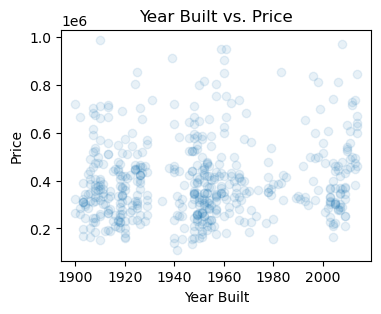

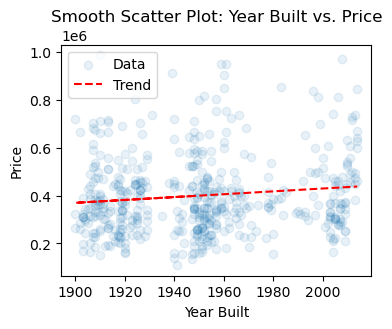

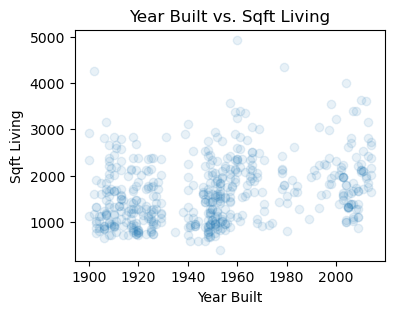

In [11]:
## Plot year built vs. price
plt.scatter(house['yr_built'], house['price'], alpha=0.1)
plt.xlabel('Year Built')
plt.ylabel('Price')
plt.title('Year Built vs. Price')
plt.gcf().set_size_inches(4, 3)
plt.show()

## Smooth scatter plot of year built vs. price
plt.scatter(house['yr_built'], house['price'], alpha=0.1, label='Data')
z = np.polyfit(house['yr_built'], house['price'], 1)
p = np.poly1d(z)
plt.plot(house['yr_built'], p(house['yr_built']), "r--", label='Trend')
plt.xlabel('Year Built')
plt.ylabel('Price')
plt.title('Smooth Scatter Plot: Year Built vs. Price')
plt.legend()
plt.gcf().set_size_inches(4, 3)
plt.show()

## Plot year built vs. sqft_living
plt.scatter(house['yr_built'], house['sqft_living'], alpha=0.1)
plt.xlabel('Year Built')
plt.ylabel('Sqft Living')
plt.title('Year Built vs. Sqft Living')
plt.gcf().set_size_inches(4, 3)
plt.show()


## Pairwise plot of price, bedrooms, and sqft_living
#pd.plotting.scatter_matrix(house[['price', 'bedrooms', 'sqft_living']], alpha=0.1, figsize=(10, 10))
#plt.show()



In [12]:
## Group by condition and calculate mean price
print(house.groupby('condition')['price'].mean().reset_index())

   condition          price
0          1  227000.000000
1          2  246749.705882
2          3  396841.120482
3          4  420201.384615
4          5  433258.152174


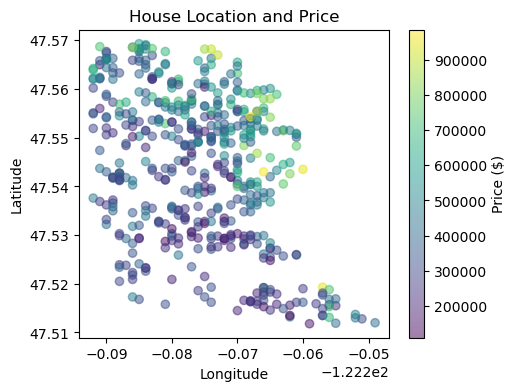

In [13]:
plt.figure(figsize=(10, 8))
sc = plt.scatter(house['long'], house['lat'], c=house['price'], cmap='viridis', alpha=0.5)
plt.colorbar(sc, label='Price ($)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('House Location and Price')
plt.gcf().set_size_inches(5, 4)
plt.show()


## K-Nearest Neighbors

In [ ]:
# We will consider this subset of features
features = ["floors", "grade", "condition", "view", "sqft_living",
            "sqft_lot", "sqft_basement", "yr_built", "yr_renovated",
            "bedrooms", "bathrooms", "lat", "long"]

Y = house['price'] / 1000
X = house[features]

## Standardize the features
scaler = StandardScaler()
X_stan = scaler.fit_transform(X)

## Split the data into training and test sets
n_train = 400
n_test = 100

idx = np.random.permutation(len(Y))
X_stan = X_stan[idx]
Y = Y.iloc[idx]

X_train = X_stan[:n_train]
X_test = X_stan[n_train:(n_train + n_test)]
Y_train = Y[:n_train]
Y_test = Y[n_train:n_train + n_test]

## Implement KNN
K = 7
Y_pred = []

for test_point in X_test:
    distances = np.sqrt(((X_train - test_point)**2).sum(axis=1))
    nearest_neighbors_indices = distances.argsort()[:K]
    Y_pred.append(Y_train.iloc[nearest_neighbors_indices].mean())

Y_pred = np.array(Y_pred)
Y_pred_baseline = Y_train.mean()

# Evaluate test error
test_error = np.sqrt(((Y_test - Y_pred) ** 2).mean())
baseline_error = np.sqrt(((Y_test - Y_pred_baseline) ** 2).mean())
print(f"Test RMSE of KNN: {test_error:.3f}   Baseline RMSE: {baseline_error:.3f}")

#print test R-squared
R2 = 1 - test_error**2 / baseline_error**2
print(f"Test R-squared of KNN: {R2:.3f}")

Test RMSE of KNN: 243.110   Baseline RMSE: 333.415
Test R-squared of KNN: 0.468


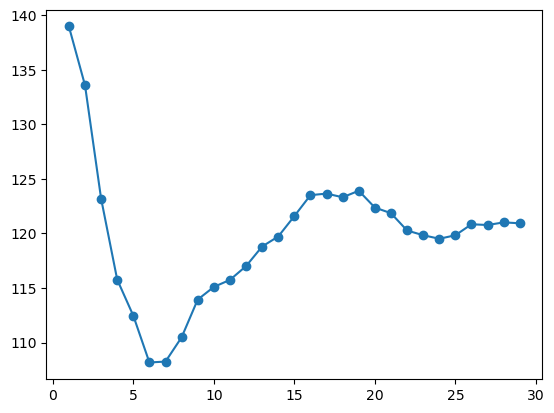

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_stan, Y, test_size=100, train_size=400, random_state=1)

all_errs = []

for K in range(1, 30):
    knn = KNeighborsRegressor(n_neighbors=K)
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)

    # Evaluate test error
    test_error = np.sqrt(((Y_test - Y_pred) ** 2).mean())
    all_errs.append(test_error)

plt.plot(range(1, 30), all_errs, marker='o')


## Linear regression    

In [11]:
## linear regression
X_stan1 = np.hstack([np.ones((X_stan.shape[0], 1)), X_stan])
X_train, X_test, Y_train, Y_test = train_test_split(X_stan1, Y, test_size=100, train_size=400, random_state=2)

betahat = np.linalg.solve(X_train.T @ X_train, X_train.T @ Y_train)
Y_pred = X_test @ betahat

test_error = np.sqrt(((Y_test - Y_pred) ** 2).mean())
baseline_error = np.sqrt(((Y_test - Y_train.mean()) ** 2).mean())

## print coefficients
print("Coefficients:")
features = X.columns
for i, f in enumerate(features):
    print(f"{f}: {betahat[i]:.3f}")


print(f"Test RMSE of linear regression: {test_error:.3f}   Baseline RMSE: {baseline_error:.3f}")

R2 = 1 - test_error**2 / baseline_error**2
print(f"Test R-squared of linear regression: {R2:.3f}")


Coefficients:
floors: 416.418
grade: 12.421
condition: 58.902
view: 18.317
sqft_living: 44.802
sqft_lot: 87.841
sqft_basement: 87.671
yr_built: -17.770
yr_renovated: -9.817
bedrooms: 6.158
bathrooms: -33.250
lat: 9.441
long: 72.392
Test RMSE of linear regression: 94.613   Baseline RMSE: 195.243
Test R-squared of linear regression: 0.765


In [12]:
## use sklearn to do linear regression
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train, Y_train)
Y_pred = linreg.predict(X_test)

test_error = np.sqrt(((Y_test - Y_pred) ** 2).mean())
baseline_error = np.sqrt(((Y_test - Y_train.mean()) ** 2).mean())

print(f"Test RMSE of linear regression: {test_error:.3f}   Baseline RMSE: {baseline_error:.3f}")

R2 = 1 - test_error**2 / baseline_error**2
print(f"Test R-squared of linear regression: {R2:.3f}")

Test RMSE of linear regression: 94.613   Baseline RMSE: 195.243
Test R-squared of linear regression: 0.765
